1.Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
sw= set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2.Dataset Loading

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/practice datas/labeled_data.csv')
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


Adding a new column to this dataset as labels which will contain the values as:

Hate Speech
Offensive Language
No Hate and Offensive

In [ ]:
data["labels"] = data["class"].map({0: "Hate Speech",
                                    1: "Offensive Language",
                                    2: "No Hate and Offensive"})

Now we only select the tweet and labels columns for the rest of the task of training a hate speech detection model:

In [ ]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [ ]:
# removing duplicate data
tweetData = data.drop_duplicates("tweet")

3.Data visualization

<Axes: xlabel='labels', ylabel='count'>

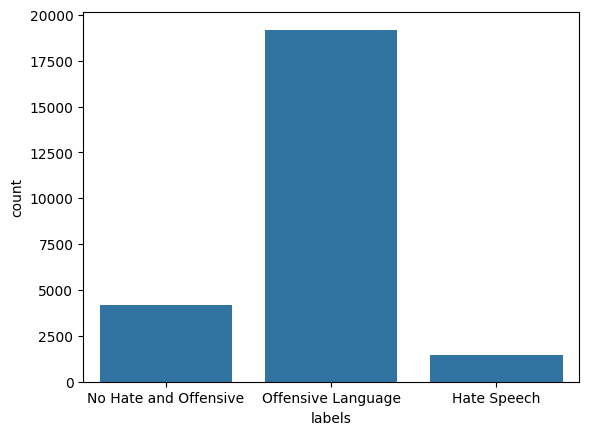

In [ ]:
sns.countplot(x='labels',data=data)

Text(0.5, 1.0, 'Distribution of sentiments')

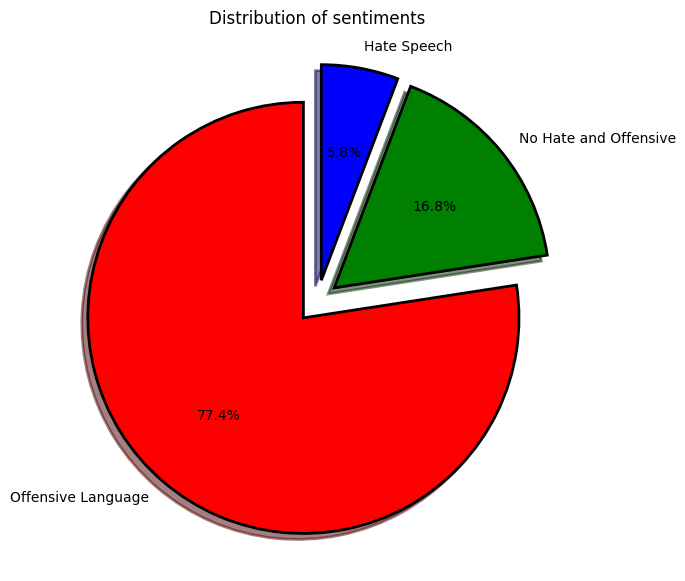

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = tweetData['labels'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

4.Data Preprocessing

In [ ]:
text=data.tweet
text

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

a.To remove special characters

In [ ]:
text=text.str.replace('[^a-zA-Z0-9]+',' ')
text

<ipython-input-9-17d87946c057>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  text=text.str.replace('[^a-zA-Z0-9]+',' ')


0         RT mayasolovely As a woman you shouldn t comp...
1         RT mleew17 boy dats cold tyga dwn bad for cuf...
2         RT UrKindOfBrand Dawg RT 80sbaby4life You eve...
3         RT C G Anderson viva based she look like a tr...
4         RT ShenikaRoberts The shit you hear about me ...
                               ...                        
24778    you s a muthaf in lie 8220 LifeAsKing 20 Pearl...
24779    you ve gone and broke the wrong heart baby and...
24780    young buck wanna eat dat nigguh like I aint fu...
24781                youu got wild bitches tellin you lies
24782     Ruffled Ntac Eileen Dahlia Beautiful color co...
Name: tweet, Length: 24783, dtype: object

b.Stemming

In [ ]:
stemmer=SnowballStemmer('english')
tk=TweetTokenizer()
text=text.apply(lambda line:[stemmer.stem(token.lower())for token in tk.tokenize(line)]).apply(lambda tokens:" ".join(tokens))
text

0        rt mayasolov as a woman you shouldn t complain...
1        rt mleew 17 boy dat cold tyga dwn bad for cuff...
2        rt urkindofbrand dawg rt 80sbaby4lif you ever ...
3         rt c g anderson viva base she look like a tranni
4        rt shenikarobert the shit you hear about me mi...
                               ...                        
24778    you s a muthaf in lie 8220 lifeask 20 pearl co...
24779    you ve gone and broke the wrong heart babi and...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                   youu got wild bitch tellin you lie
24782    ruffl ntac eileen dahlia beauti color combin o...
Name: tweet, Length: 24783, dtype: object

c.Tokenization

In [ ]:
text=text.apply(lambda line:[token for token in tk.tokenize(line)if token not in sw]).apply(lambda tokens:" ".join(tokens))
text

0        rt mayasolov woman complain clean hous amp man...
1        rt mleew 17 boy dat cold tyga dwn bad cuffin d...
2        rt urkindofbrand dawg rt 80sbaby4lif ever fuck...
3               rt c g anderson viva base look like tranni
4        rt shenikarobert shit hear might true might fa...
                               ...                        
24778    muthaf lie 8220 lifeask 20 pearl corey emanuel...
24779      gone broke wrong heart babi drove redneck crazi
24780    young buck wanna eat dat nigguh like aint fuck...
24781                       youu got wild bitch tellin lie
24782    ruffl ntac eileen dahlia beauti color combin p...
Name: tweet, Length: 24783, dtype: object

d.Vectorization

In [ ]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(text)

In [ ]:
X=X.toarray()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
tweetData['labels']=le.fit_transform(tweetData['labels'])

In [ ]:
y = tweetData['labels']
y

0        1
1        2
2        2
3        2
4        2
        ..
24778    2
24779    1
24780    2
24781    2
24782    1
Name: labels, Length: 24783, dtype: int64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

5.Data modeling & Perfomance measure

Random Forest Classifier

____________________ Random Forest Classifier ____________________
              precision    recall  f1-score   support

           0       0.62      0.10      0.18       439
           1       0.85      0.81      0.83      1241
           2       0.91      0.97      0.94      5755

    accuracy                           0.89      7435
   macro avg       0.79      0.63      0.65      7435
weighted avg       0.88      0.89      0.87      7435

____________________ Confusion Matrix Display ____________________


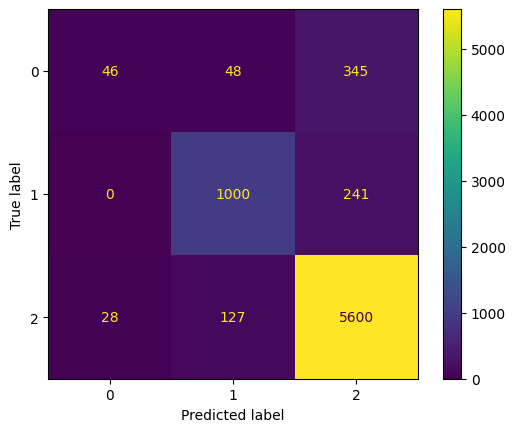

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print('_'*20,'Random Forest Classifier','_'*20)
print(classification_report(y_test,y_pred))
print('_'*20,'Confusion Matrix Display','_'*20)
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred))

AdaBoost Classifier

In [ ]:
ab=AdaBoostClassifier()
ab.fit(X_train,y_train)
y_pred=ab.predict(X_test)
print('_'*20,'AdaBoost Classifier','_'*20)
print(classification_report(y_test,y_pred))
print('_'*20,'Confusion Matrix Display','_'*20)
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred))

Support Vetor Classifier

In [ ]:
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('_'*20,'Support Vector Classifier','_'*20)
print(classification_report(y_test,y_pred))
print('_'*20,'Confusion Matrix Display','_'*20)
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred))

Here, random Forest classifier have the highest accuracy.